In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/QROMP/")

 Activating environment at `/media/mat/HDD/QROMP/Project.toml`


In [117]:
using Revise
using LinearAlgebra
using Statistics
using BenchmarkTools
using QROMP
using Permutations
using Test
using Plots
using Convex

┌ Info: Precompiling Convex [f65535da-76fb-5f13-bab9-19810c17039a]
└ @ Base loading.jl:1278


In [140]:
ψ = randn(100, 20)
u = randn(100)
m, n = size(ψ)
ctrue = ψ\u

# Force a greedy approach over the entire set of indices
# With LS
@time idxls, cls, ϵls = lsomp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With QR
@time idxqr, cqr, ϵqr = qromp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With pivoted QR
idxpivot, cpivot, ϵpivot = pivotedqr(ψ, u; invert = true, verbose = true, ϵrel = eps())


# @test norm(idxls - idxqr)<1e-14
@test norm(ctrue[idxqr]-cqr)<1e-14
@test norm(ctrue[idxls]-cls)<1e-14
@test norm(ctrue[idxpivot]-cpivot)<1e-14
# @test norm(ϵls-ϵqr)<1e-14

  0.000399 seconds (1.95 k allocations: 1.864 MiB)
  0.000205 seconds (387 allocations: 1.503 MiB)


Test Passed

In [142]:
idxpivot, cpivot, ϵpivot = greedysolver("pivotedqr", ψ, u; invert = true, verbose = true, ϵrel = eps())


([5, 11, 6, 2, 16, 14, 8, 20, 1, 10, 13, 17, 9, 3, 4, 7, 19, 12, 15, 18], [-0.01371236338326653, -0.09715495136059164, -0.08528761710010922, -0.10604677244716953, 0.018917400189020744, -0.12303740096162322, -0.14602402865042569, -0.04540395144307271, -0.06932459670875322, -0.013436624487337097, -0.027124733100042646, 0.13674208330637927, 0.15772046526760053, -0.09056306608707786, 0.06387829018903118, -0.22846099884099105, -0.12997282030069143, -0.028917162690221505, -0.02429097940480855, -0.03129974626008526], [9.264228100986408, 9.244981000656699, 9.238790041687269, 9.192027022793567, 9.128262123127325, 9.106697925724326, 9.023052208480681, 8.95303547757653, 8.945410539376788, 8.921262328829723  …  8.917802046950163, 8.769233296362351, 8.669405102360008, 8.634773575572966, 8.625677569987806, 8.404467816437942, 8.329805276793197, 8.323725486097972, 8.321164295381372, 8.318051150069065])

In [138]:
typeof("pivotedqr")

String

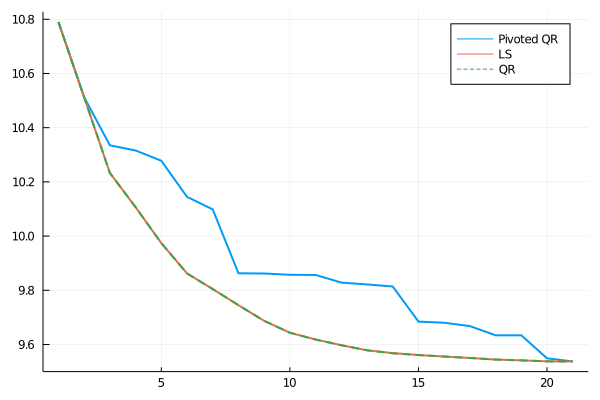

In [134]:
plot(ϵpivot, linewidth = 2, label = "Pivoted QR")
plot!(ϵls, linewidth = 2, label = "LS")
plot!(ϵqr, linewidth = 2, label = "QR", linestyle = :dash)